# Quickstart Guide

This guide will give a quick intro to visualising deep networks with visual. First, we'll load in a model, then perform a simple gradient ascent on an image and see how it can be improved by working in Fourier space.

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU with

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install Visual

First we install visual if needed.

In [ ]:
try:
    import visual
except:
    !pip install -q git+https://github.com/pytorchbearer/visual
    import visual

print(visual.__version__)

## Load an Inception Network

Our first step is to load a pre-trained Inception network (adapted from torchvision) that will be used for this tutorial.

Models in visual need to store intermediate tensors in the state passed to the forward function by [torchbearer](https://github.com/pytorchbearer/torchbearer). We'll cover this in more detail in a separate tutorial but one way to do it for now is to wrap the model with the `IntermediateLayerGetter` (adapted from torchvision).

We also wrap our model here with RedirectReLUs. This model wrapper changes the ReLU gradient for the first 16 batches in order to get around the potential dead ReLU problem (that is, ReLUs with zero gradient).

In [2]:
from visual.models import inception_v3, IntermediateLayerGetter
from visual import RedirectReLUs

model = IntermediateLayerGetter(RedirectReLUs(inception_v3(True, False)))
print(model.layer_names)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


['model', 'model_Conv2d_1a_3x3', 'model_Conv2d_1a_3x3_conv', 'model_Conv2d_1a_3x3_bn', 'model_Conv2d_1a_3x3_relu', 'model_Conv2d_2a_3x3', 'model_Conv2d_2a_3x3_conv', 'model_Conv2d_2a_3x3_bn', 'model_Conv2d_2a_3x3_relu', 'model_Conv2d_2b_3x3', 'model_Conv2d_2b_3x3_conv', 'model_Conv2d_2b_3x3_bn', 'model_Conv2d_2b_3x3_relu', 'model_MaxPool2b', 'model_Conv2d_3b_1x1', 'model_Conv2d_3b_1x1_conv', 'model_Conv2d_3b_1x1_bn', 'model_Conv2d_3b_1x1_relu', 'model_Conv2d_4a_3x3', 'model_Conv2d_4a_3x3_conv', 'model_Conv2d_4a_3x3_bn', 'model_Conv2d_4a_3x3_relu', 'model_MaxPool4a', 'model_Mixed_5b', 'model_Mixed_5b_branch1x1', 'model_Mixed_5b_branch1x1_conv', 'model_Mixed_5b_branch1x1_bn', 'model_Mixed_5b_branch1x1_relu', 'model_Mixed_5b_branch5x5_1', 'model_Mixed_5b_branch5x5_1_conv', 'model_Mixed_5b_branch5x5_1_bn', 'model_Mixed_5b_branch5x5_1_relu', 'model_Mixed_5b_branch5x5_2', 'model_Mixed_5b_branch5x5_2_conv', 'model_Mixed_5b_branch5x5_2_bn', 'model_Mixed_5b_branch5x5_2_relu', 'model_Mixed_5b_br

## A Simple Visualisation

The core API of visual largely follows that of the excellent [`lucid` for Tensorflow](https://github.com/tensorflow/lucid). Importantly, to perform a visualisation, we require a `Criterion` and an `Image`. `Image` objects can be created either from their classes, or using the helper function `image`. First, we'll use a `TensorImage`, the simplest image type in visual. `Criterion` objects can be found in `visual.loss`, for now we'll use the simple `Channel` criterion which looks to maximise the output from a particular channel in the input.

In [3]:
import torch
from torchvision.transforms import Normalize

import visual
from visual import Channel, TensorImage
from visual.transforms import RandomRotate, RandomScale, Compose

normalize = Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

criterion = Channel(2, 'model_Mixed_6b_branch1x1_conv')
image = TensorImage(torch.rand(3, 128, 128), correlate=False, transform=normalize).sigmoid()

Next, we perform a gradient ascent using the `Ascent` class. This uses the `torchbearer` library underneath to perform plotting and output to file or tensorboard. It can either be used as a callback or run on its own. We'll cover the callback option in a seperate notebook.

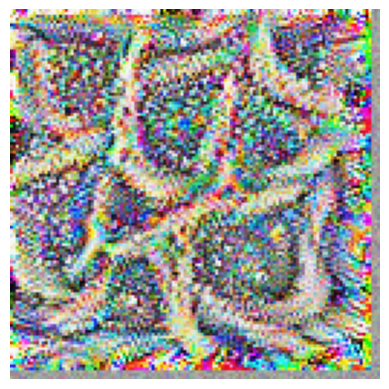

In [4]:
%matplotlib inline

from visual import Ascent
Ascent(image, criterion, steps=256).to_pyplot().run(model, device='cuda', verbose=0)

As can be seen, the image is quite noisy; arguably too noisy too provide any insight on the learned representation.

## Improvements

Here we'll have a look at improving our image. The techniques discussed here are brilliantly covered in more detail in the distill.pub paper, [Feature Visualisation](https://distill.pub/2017/feature-visualization/)

### Correlate Colours

You may have noticed that in the last section we set `correlate=False` when we created our image. When `correlate` is `True` the image channels will be correlated according to known covariance statistics computed from ImageNet. This is enables a more natural notion of colour than is present in our example above. Let's take a look:

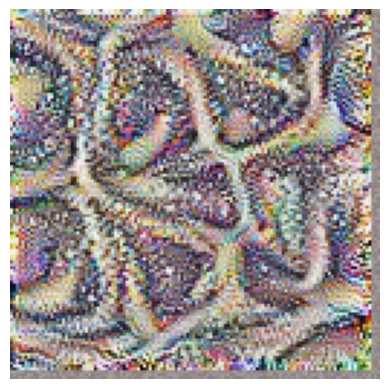

In [5]:
criterion = Channel(2, 'model_Mixed_6b_branch1x1_conv')
image = TensorImage(torch.rand(3, 128, 128), correlate=True, transform=normalize).sigmoid()

Ascent(image, criterion, steps=256).to_pyplot().run(model, device='cuda', verbose=0)

Well the colour has definitely improved. However, it's still not very clear what this particular cell has learned.

### Frequency Penalisation

The next step discussed in [Olah et. al.](https://distill.pub/2017/feature-visualization/) is too look at what happens when we add some loss terms which encourage low frequency images. We can do this with visual by importing the relevant `Criterion` objects: `Blur`, `L1` and `TotalVariation`.

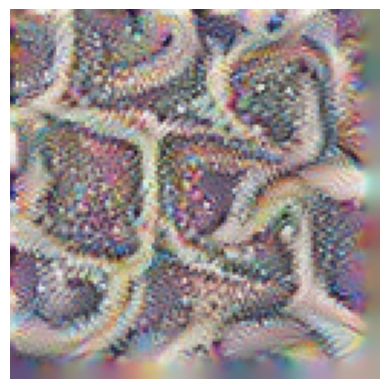

In [6]:
from visual import Blur, L1, TotalVariation

criterion = Channel(2, 'model_Mixed_6b_branch1x1_conv')
criterion -= 5e-3 * Blur()
criterion -= 2e-6 * L1(0.5)
criterion -= 1e-5 * TotalVariation()

image = TensorImage(torch.rand(3, 128, 128), correlate=True, transform=normalize).sigmoid()

Ascent(image, criterion, steps=256).to_pyplot().run(model, device='cuda', verbose=0)

That looks a little better, but it takes a while to tune all those parameters and we still can't say much about what this filter has learned. Perhaps a different form of regularisation is needed.

### Augmentation

For the next step, we can add some augmentation. We need our augmentations to be differentiable, so we can't use torchvision here. Instead we'll look at `RandomRotate`, `RandomScale` and `SpatialJitter` from `visual.transforms`:

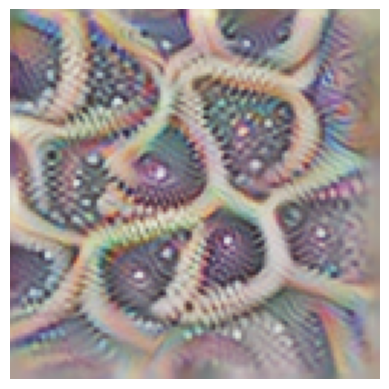

In [7]:
from visual import transforms

transform = transforms.Compose([
    transforms.SpatialJitter(2),
    transforms.RandomScale([1.1 ** (n / 10.) for n in range(-10, 11)]),
    transforms.RandomRotate(list(range(-5, 6)), padding_mode='border'),
    normalize
])

image = TensorImage(torch.rand(3, 128, 128), correlate=True, transform=transform).sigmoid()

Ascent(image, criterion, steps=256).to_pyplot().run(model, device='cuda', verbose=0)

That's looking a bit better! The final step is to use a differentiable image parameterisation, the Fourier transform.

### Working in Fourier Space

The final step in [Olah et. al.](https://distill.pub/2017/feature-visualization/) is to introduce the notion of image parameterisation in the Fourier domain. Here, we instead gradient ascend on the parameters of a Fourier image which is converted back to the real domain using `torch.irfft` on each forward pass. In visual, we can acheive this with the `FFTImage` class. Note that we don't use frequency penalisation here as explained in the distil paper. Here's how it looks:

In [8]:
from visual import FFTImage

criterion = Channel(2, 'model_Mixed_6b_branch1x1_conv')

image = FFTImage((3, 128, 128), correlate=True, transform=transform).sigmoid()

Ascent(image, criterion, steps=256).to_file('vis.png').to_pyplot().run(model, device='cuda', verbose=0)

Exception: [AttributeError("'FFTImage' object has no attribute 'image'")]

That's more like it! Now we can begin to see the kinds of features the network has learned. That's the end of our breif introduction to feature visualisation with visual. There's still plenty more that can be done which we'll go into in subsequent tutorials. If you want to learn more, the fantastic resources available at [distill.pub](https://distill.pub/) and the [lucid library](https://github.com/tensorflow/lucid) will give you plenty to think about.